---
# <p style="text-align: center;">__Trajectories-Clustering__</p> 
---

### ■ __Libraries__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

### ■ __Grid Class__

In [2]:
class Grid(object):
    
    """Return and plot the clustered trajectories
    x_coord : <numpy array> the x coordinates
    y_coord : <numpy array> the y coordinates
    n_rects : <integer>     n_cells**2 is the number of cells in the grid
    """
    
    def __init__(self, x_coord:np.array=None, y_coord:np.array=None, n_cells:int=200):
        self.x_coord = x_coord ## The x coordinates of trajectories
        self.y_coord = y_coord ## The y coordinates of trajectories
        self.n_cells = n_cells ## the square root of the number of cells in the grid
        
        ## getting the edge points and cells width and height of the grid
        self.get_edges_points()
        
        ## initialize the grid with 0 values 
        self.initiate_grid()
        
        ## getting the rectangle for the trajectories
        self.get_input_trajectories_cells()
        
        
    def initiate_grid(self):    
        
        """return a zero numpy array with the shape (n_rect x n_rects)"""
        
        ## value 0 means that the cell is empty and 1 means that it's occupied
        self.grid = np.zeros((self.n_cells + 1, self.n_cells + 1))
        
    
    def get_edges_points(self):
        
        """return the corner points of the grid and the rectangle's hight and width"""
       
        ## the edge coordinates of the grid
        self.x0, self.y0 = min(self.x_coord)-1, min(self.y_coord)-1
        self.x1, self.y1 = max(self.x_coord)+1, max(self.y_coord)+1
        
        ## the rectangles width and height
        self.cell_width  = (self.x1 - self.x0) / (self.n_cells - 1)
        self.cell_height = (self.y1 - self.y0) / (self.n_cells - 1) 
    
    
    def get_input_trajectories_cells(self):
        
        """return the projection of the x and y coordinates 
        of the input trajectories on the center of the cells of the grid"""
        
        for x, y in zip(self.x_coord, self.y_coord):
            
            ## get the cell that corresponds to the coordiantes x and y
            i, j = self.get_cell(x, y)
            
            ## swaping the value of the cell (i, j) to 1
            self.grid[i, j] = 1
            
    
    def get_cell(self, x:float, y:float) -> tuple:
        
        """return the cell in which the coordinates x and y are in"""
        
        ## getting the cell in wich the coordinate (x, y) is in.
        i = (x - self.x0) // self.cell_width  + 1
        j = (y - self.y0) // self.cell_height + 1
        return int(i), int(j)
    
    
    def get_cell_coordinates(self, i:int, j:int) -> tuple:
        
        """return the coordinates of the cell (i, j)"""
        
        x, y = self.cell_width * i, self.cell_height * j
        x = self.x0 + self.cell_width  * (x // self.cell_width)
        y = self.y0 + self.cell_height * (y // self.cell_height)
        return x, y         
        
        
    def get_cell_center(self, i:int, j:int) -> tuple: 
        
        """return the coordinates of the center of the cell (i, j)"""
        
        a, b = self.get_cell_coordinates(i, j)
        return a + self.cell_width / 2 , b + self.cell_height / 2

    
    def get_cell_neighbours(self, i:int, j:int) -> list:
        
        """return the list of neighbours of the cell (i, j)"""
        
        for v in range(max(0, i-4), min(i+5, len(self.grid))):
            for u in range(max(0, j-4), min(j+5, len(self.grid[0]))):
                if self.grid[(v, u)] and any([i!=v, j!=u]):
                    return v, u

                
    def get_trajectories_cells(self) -> list:
        
        """return the cells of clustered trajectories"""
        
        trajectories = []
        for i in range(len(self.grid)):
            for j in range(len(self.grid[0])):
                if self.grid[(i, j)]:
                    a, b = i, j
                    trajectory = [[a, b]]
                    self.grid[(a, b)] = 0
                    while all([self.get_cell_neighbours(a,b)]) :
                        trajectory.append([a, b])
                        a,b = self.get_cell_neighbours(a, b)
                        self.grid[(a, b)] = 0
                    trajectories.append(trajectory)
        return np.array(trajectories)
    
        
    def get_trajectories_coordinates(self, trajectories:np.array)->np.array:
        
        """return the coordinates of clustered trajectories"""
        
        trajectories_coordinates = []
        for trajectory in trajectories:
            x_coord, y_coord = [], []
            for cell in trajectory:
                x, y = self.get_cell_center(*cell)
                x_coord.append(x)
                y_coord.append(y)
            trajectories_coordinates.append([x_coord, y_coord])
        return np.array(trajectories_coordinates) 
    
    
    def save_clustered_trajectories(self, file_name:str):
        
        """save the clustered trajectories with the given file name"""
        
        ## creating x coordinates and y coordinates
        x_coordinates = []
        y_coordinates = []
        for trajectory in self.clustered_trajectories:
            for x, y in zip(trajectory[0], trajectory[1]):
                x_coordinates.append(x)
                y_coordinates.append(y)
            
        ## create the data frame    
        coordinates_dict = {'x' : x_coordinates, 'y' : y_coordinates}
        df = pd.DataFrame.from_dict(coordinates_dict)
        df.to_csv(f'{file_name}.csv')
    
            
    def plot_clustered_trajectories(self, trajectories_centers:np.array):
        
        """plot the clustered trajectories"""
        
        self.clustered_trajectories = self.get_trajectories_coordinates(trajectories_centers)
        for e, trajectory in enumerate(self.clustered_trajectories):
            plt.scatter([trajectory[0][0], trajectory[0][-1]], [trajectory[-1][0], trajectory[1][-1]])
            plt.plot(trajectory[0], trajectory[1], label=f'trajectory {e}')
        

    def plot(self):
        
        """draw the clustered trajectories"""
        
        ## using the seaborn style
        plt.style.use('seaborn')
        
        ## resizing the plot
        plt.rcParams["figure.figsize"] = 8, 8
        
        ## getting the trajectories cells
        trajectories = self.get_trajectories_cells()
        
        ## plotting the clustered trajectories
        self.plot_clustered_trajectories(trajectories)
        plt.title('Clustered Trajectories')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(bbox_to_anchor=(1.2, 1))
        plt.show()

### ■ __Trajectory Class__

In [3]:
class Trajectory(object):

    """return and plot the input trajectories to be clustered
    file_path : <string> the file path of the data"""
    
    def __init__(self, file_path:str=None): 
        ## the file path
        self.file_path = file_path
        
        ## test counter
        self.test = 0
        
        
    def __repr__(self):
        
        """represent the trajectory with the name of the file"""
        
        return self.file_path.split('/')[-1]
        
        
    def next_test(self):
        
        """setting the value of test counter to its next value"""
        
        self.test += 1
        
        
    def get_coord(self):
        
        """getting the coordinates of the trajectories from the csv file"""
        
        ## reading the csv file
        df = pd.read_csv(self.file_path, names=['x', 'y', 'nx', 'ny'], sep=' ')
        
        ## drop None valeus
        df = df.dropna(axis=0, how="any")
        
        ## drop non-numeric values
        df = df.select_dtypes(include=['float64'])
        
        self.x_coord = df['x']
        self.y_coord = df['y']
        
        
    def plot(self):
        
        """plot the input trajectories"""
        
        plt.style.use('seaborn')
        plt.plot(self.x_coord, self.y_coord, label='input trajectories')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('The input trajectories')
        plt.legend()
        plt.show()

### ■ __Checking method__

In [4]:
def check(trajectory:Trajectory):
    
    """applying the TDD method to the Trajectory class"""
    
    ## cheking if the file path exists
    if trajectory.test == 0:
        if os.path.exists(trajectory.file_path):
            return 'file path exists'
     
    ## checking if the file is a csv or txt file
    if trajectory.test == 1:
        if trajectory.file_path.endswith('.csv'):
            trajectory.df = pd.read_csv(trajectory.file_path)
            return 'file format is correct'
            
        if trajectory.file_path.endswith('.txt'):
            trajectory.df = pd.read_csv(trajectory.file_path, sep=' ')
            trajectory.df = trajectory.df.dropna(axis=0, how="any")
            return 'file format is correct'
        
    ## cheking if the file is not empty        
    if trajectory.test == 2:
        if trajectory.df.shape[0] >= 3 and trajectory.df.shape[1] >= 2:
            return 'file is not empty'
        
    ## cheking if the data shape is correct    
    if trajectory.test == 3:
        if trajectory.df.shape[1] == 4:
            trajectory.df.columns = ['x', 'y', 'nx', 'ny']
            return 'all data is there'

    ## cheking the format of the data
    if trajectory.test == 4:
        if (trajectory.df[['x', 'y']].dtypes == 'float64').all() or (trajectory.df[['x', 'y']].dtypes == 'int64').all():
            trajectory.df = trajectory.df.select_dtypes(include=['float64'])
            return 'data format is correct'
    
    ## cheking if coordinates are uploaded succesfuly
    if trajectory.test == 5:
        trajectory.get_coord()
        print(f"Trajectory '{trajectory}' is uploaded succesfuly")
        return 'trajectory coordinates are uploaded succesfuly'

### ■ __Test Examples__

In [5]:
## the file path
file_path = 'cabspottingdata/new_uvreoipy.txt'

## the trajectry of this file
trajectory = Trajectory(file_path)

### ■ __Test Class__

In [6]:
class Test(object):
    
    """test the trajectory class
    trajectory : <Trajectory> the trajectory to be tested"""
    
    def __init__(self, trajectory:Trajectory=None):
        self.trajectory = trajectory
        
        ## cheking the trajectory
        self.test_upload_coordinates()
        
    ## test 0
    def test_file_existence(self):

        """cheking the existence of the file path"""

        assert check(self.trajectory) == 'file path exists'    

    ## test 1
    def test_file_format(self):

        """cheking the file format"""

        self.test_file_existence()
        self.trajectory.next_test()
        assert check(self.trajectory) == 'file format is correct'

    ## test 2
    def test_empty_file(self):

        """cheking that the file is not empty"""

        self.test_file_format()
        self.trajectory.next_test()
        assert check(self.trajectory) == 'file is not empty'

    ## test 3
    def test_all_data_there(self):

        """cheking that all data is there"""

        self.test_empty_file()
        self.trajectory.next_test()
        assert check(self.trajectory) == 'all data is there'    

    ## test 4
    def test_data_format(self):

        """cheking the data format is correct"""

        self.test_all_data_there()
        self.trajectory.next_test()
        assert check(self.trajectory) == 'data format is correct'

    ## test 5
    def test_upload_coordinates(self):

        """cheking the coordinates upload"""

        self.test_data_format()
        self.trajectory.next_test()
        assert check(self.trajectory) == 'trajectory coordinates are uploaded succesfuly'

### ■ __Examples__

#### __files path__

In [7]:
file_path1 = 'cabspottingdata/new_uvreoipy.txt'
file_path2 = 'cabspottingdata/new_abboip.txt'
file_path3 = 'cabspottingdata/new_akgicjud.txt'
file_path4 = 'cabspottingdata/new_aiwalb.txt'
file_path5 = 'cabspottingdata/new_ugthfu.txt'

#### __The input Trajectories__

In [8]:
trajectory1 = Trajectory(file_path1)
trajectory2 = Trajectory(file_path2)
trajectory3 = Trajectory(file_path3)
trajectory4 = Trajectory(file_path4)
trajectory5 = Trajectory(file_path5)

#### __Tests__

In [9]:
test1 = Test(trajectory1)
test2 = Test(trajectory2)
test3 = Test(trajectory3)
test4 = Test(trajectory4)
test5 = Test(trajectory5)

Trajectory 'new_uvreoipy.txt' is uploaded succesfuly
Trajectory 'new_abboip.txt' is uploaded succesfuly
Trajectory 'new_akgicjud.txt' is uploaded succesfuly
Trajectory 'new_aiwalb.txt' is uploaded succesfuly
Trajectory 'new_ugthfu.txt' is uploaded succesfuly


#### __The clustered Trajectories__

- #### First Case : the number of cells in the grid (500x500)

In [10]:
grid1 = Grid(trajectory1.x_coord, trajectory1.y_coord, n_cells=500)
grid2 = Grid(trajectory2.x_coord, trajectory2.y_coord, n_cells=500)
grid3 = Grid(trajectory3.x_coord, trajectory3.y_coord, n_cells=500)
grid4 = Grid(trajectory4.x_coord, trajectory4.y_coord, n_cells=500)
grid5 = Grid(trajectory5.x_coord, trajectory5.y_coord, n_cells=500)

- #### Ploting the result

- #### 1.

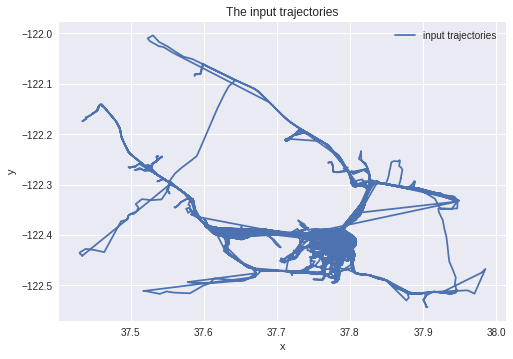

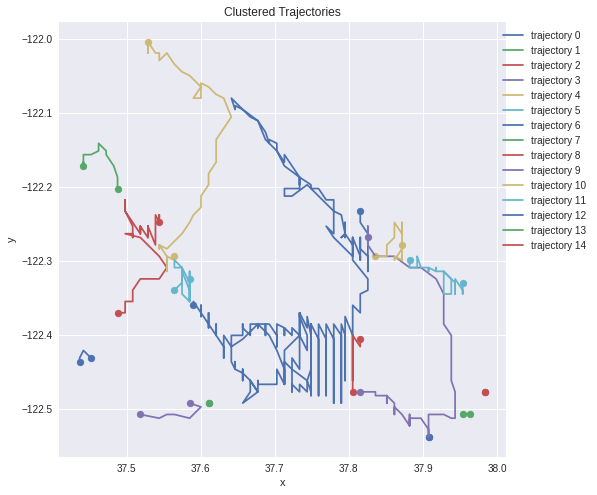

In [11]:
trajectory1.plot()
grid1.plot()

#### 2.

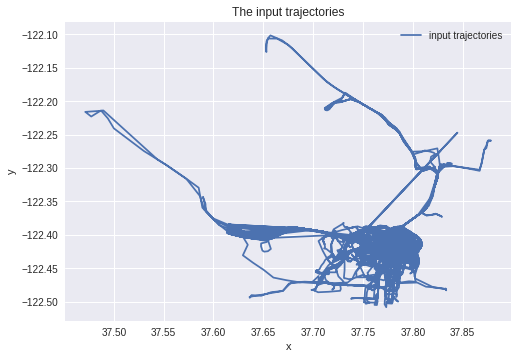

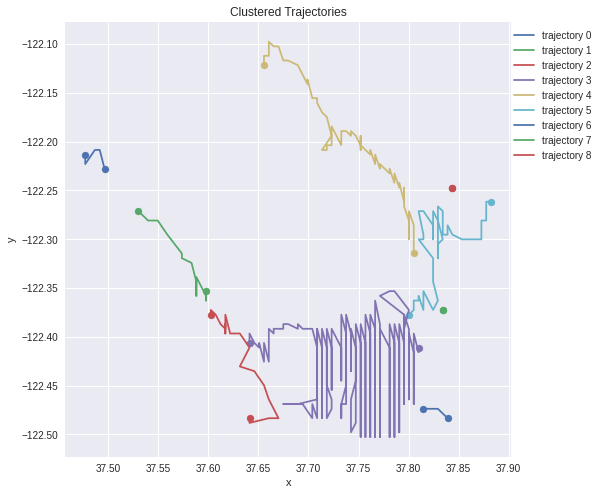

In [12]:
trajectory2.plot()
grid2.plot()

#### 3.

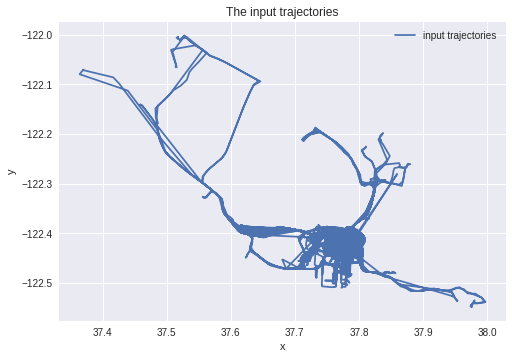

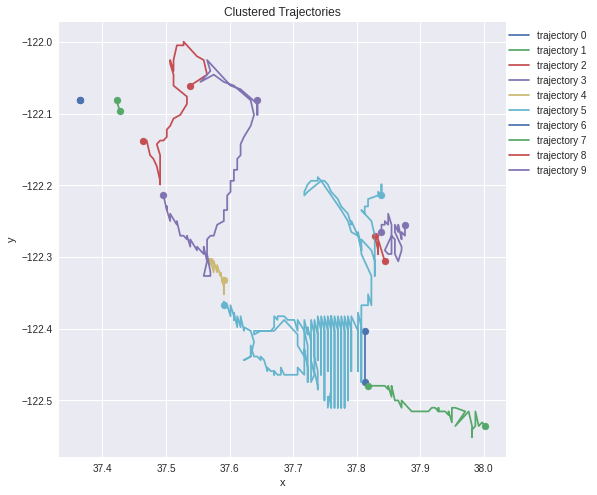

In [13]:
trajectory3.plot()
grid3.plot()

#### 4.

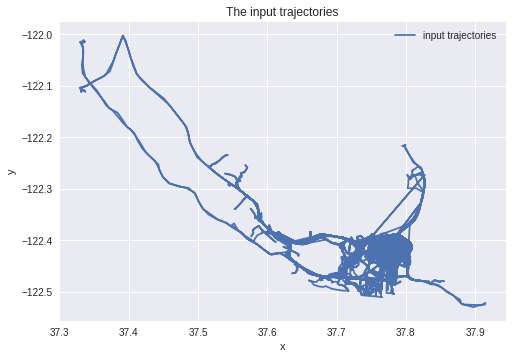

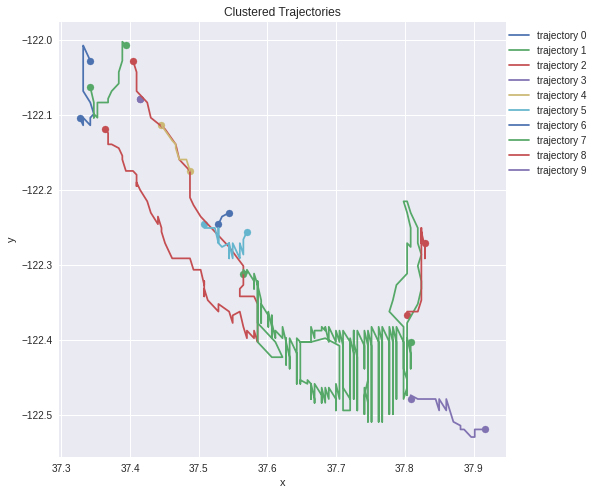

In [14]:
trajectory4.plot()
grid4.plot()

#### 5.

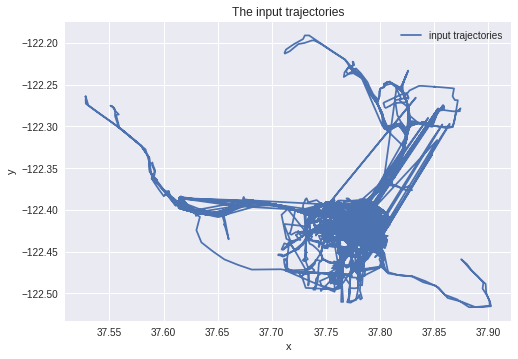

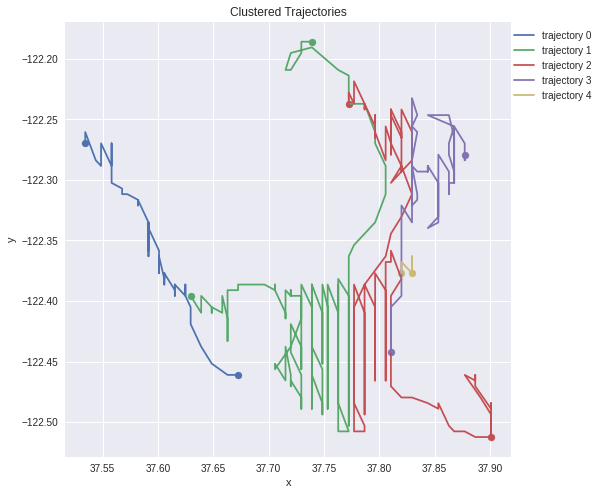

In [15]:
trajectory5.plot()
grid5.plot()

- #### Second case : the number of the cells in the grid is (200x200) 

In [16]:
grid11  = Grid(trajectory1.x_coord, trajectory1.y_coord, n_cells=200)
grid22 = Grid(trajectory2.x_coord, trajectory2.y_coord, n_cells=200)
grid33  = Grid(trajectory3.x_coord, trajectory3.y_coord, n_cells=200)
grid44  = Grid(trajectory4.x_coord, trajectory4.y_coord, n_cells=200)
grid55 = Grid(trajectory5.x_coord, trajectory5.y_coord, n_cells=200)

- #### Ploting the result

- 1.

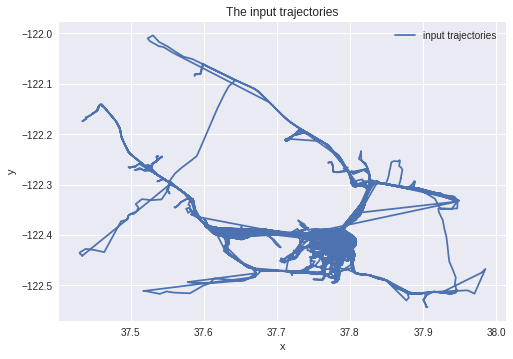

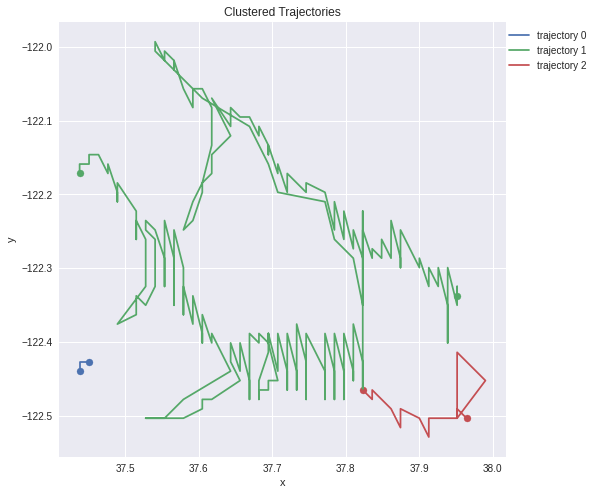

In [17]:
trajectory1.plot()
grid11.plot()

- 2.

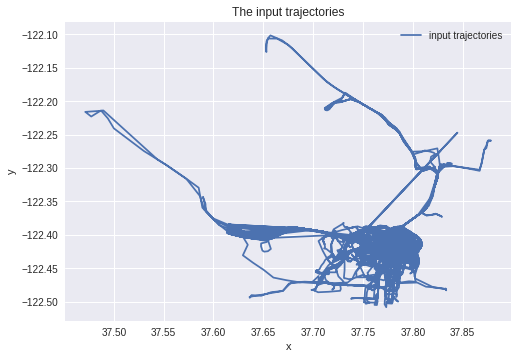

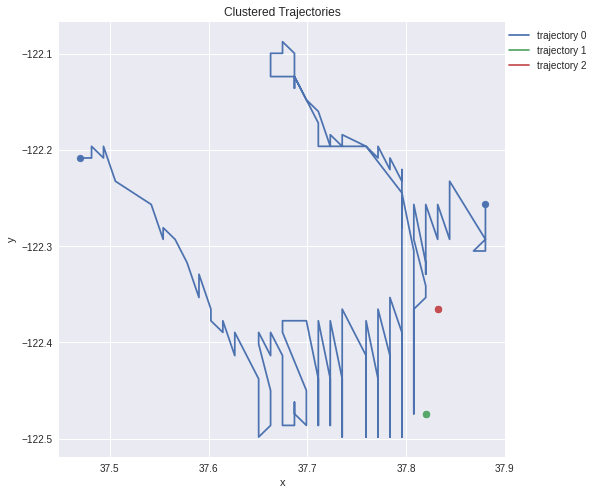

In [18]:
trajectory2.plot()
grid22.plot()

- 3.

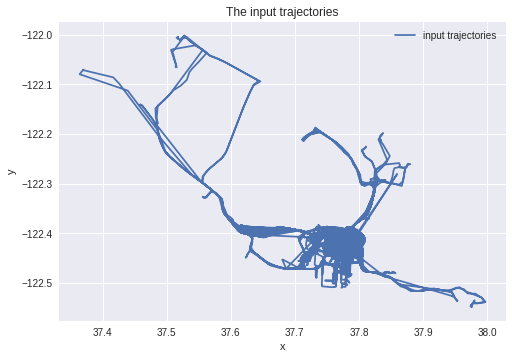

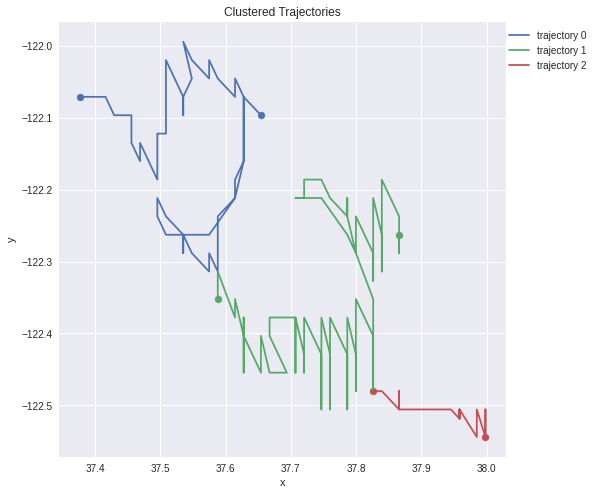

In [19]:
trajectory3.plot()
grid33.plot()

- 4.

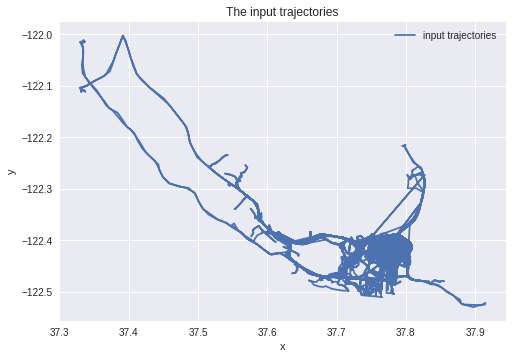

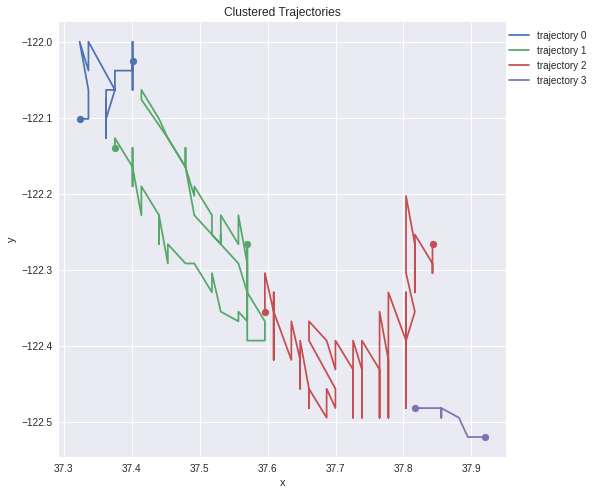

In [20]:
trajectory4.plot()
grid44.plot()

- 5.

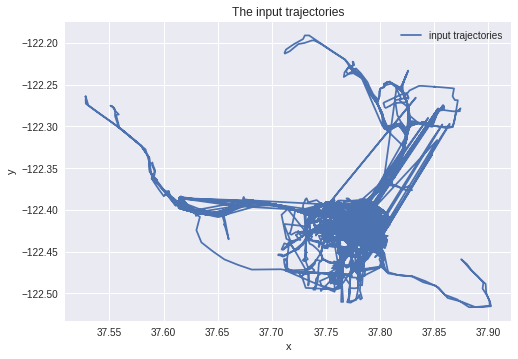

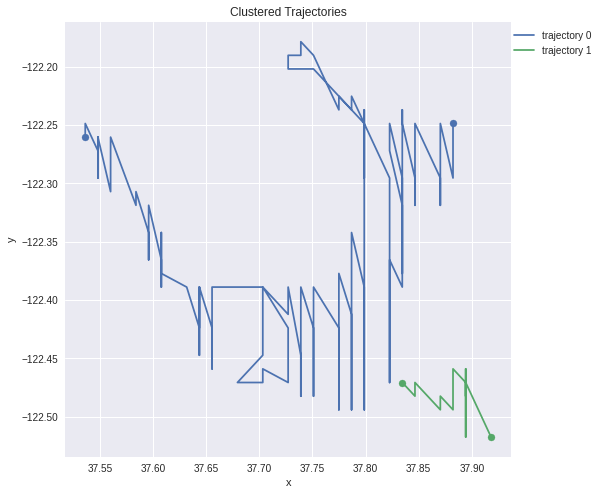

In [21]:
trajectory5.plot()
grid55.plot()